In [1]:
import numpy as np
import pandas as pd

In [3]:
crime_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso/integer_valued_ts/crime_888_data.xlsx')
# "C:\Users\michelj8\Documents\GitHub\expo_smooth_lasso\integer_valued_ts\crime_888_data.xlsx"

In [4]:
crime_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190717494,2019-10-02,2019-10-02,1355,7,Wilshire,732,2,888,TRESPASSING,...,IC,Invest Cont,888.0,NaN,NaN,NaN,6300 MARYLAND DR,NaN,34.0670,-118.3647
1,191111876,2019-06-12,2019-06-11,1130,11,Northeast,1162,2,888,TRESPASSING,...,IC,Invest Cont,888.0,NaN,NaN,NaN,SUNSET,VERMONT,34.0982,-118.2918
2,190817880,2019-11-05,2019-11-05,1004,8,West LA,829,2,888,TRESPASSING,...,IC,Invest Cont,888.0,NaN,NaN,NaN,10200 SANTA MONICA BL,NaN,34.0581,-118.4236
3,190128073,2019-11-27,2019-11-27,2130,1,Central,101,2,888,TRESPASSING,...,IC,Invest Cont,888.0,NaN,NaN,NaN,1100 W SUNSET BL,NaN,34.0685,-118.2460
4,190709386,2019-04-18,2019-04-12,1250,7,Wilshire,752,2,888,TRESPASSING,...,IC,Invest Cont,888.0,NaN,NaN,NaN,1000 S FAIRFAX AV,NaN,34.0558,-118.3706


In [5]:
ts_df = crime_data.groupby(['DATE OCC']).count()[['DR_NO']].reset_index()
ts_df['year-month'] = ts_df['DATE OCC'].apply(lambda s: str(s)[0:7])

ts_df = ts_df.groupby('year-month').sum()
ts_df.columns = ['Y']

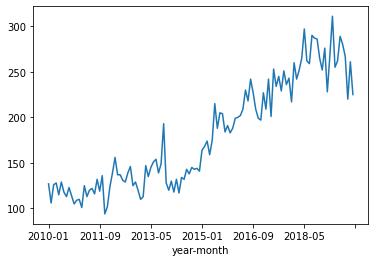

In [6]:
ts_df['Y'].plot()

In [7]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_df, (1,0)).fit()
model.params

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      179.197757
ar.L1.Y      0.932710
dtype: float64

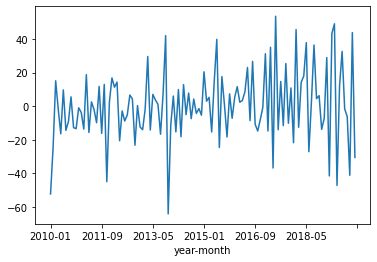

In [8]:
model.resid.plot()

In [9]:
ts_df['delta'] = ts_df['Y'].diff(1)
ts_df['abs_delta'] = np.abs(ts_df['delta'])

const          0.982210
ar.L1.delta   -0.471117
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


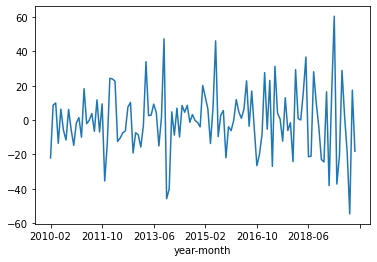

In [10]:
model = ARMA(ts_df['delta'].dropna(), (1,0)).fit()
print(model.params)
model.resid.plot()

const              16.438673
ar.L1.abs_delta     0.370576
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


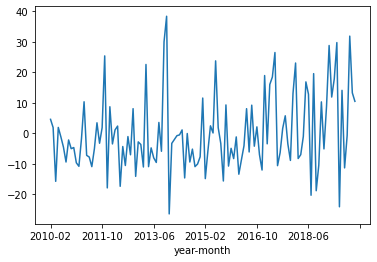

In [11]:
model = ARMA(ts_df['abs_delta'].dropna(), (1,0)).fit()
print(model.params)
model.resid.plot()

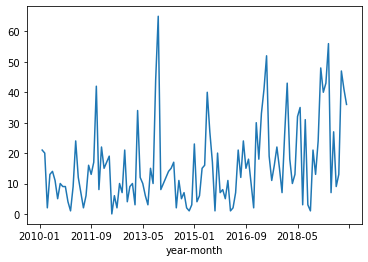

In [12]:
ts_df['abs_delta'].plot()

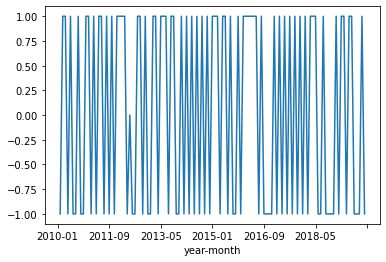

In [13]:
def sgn(x):
    if x == 0:
        return 0
    if x>0:
        return 1
    if x<0:
        return -1

ts_df['sign_dif'] = ts_df['delta'].apply(lambda s: sgn(s))
ts_df['sign_dif'].plot()

In [14]:
model = ARMA(ts_df['sign_dif'].dropna(), (1,0)).fit()
print(model.params)

const             0.054988
ar.L1.sign_dif   -0.347002
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


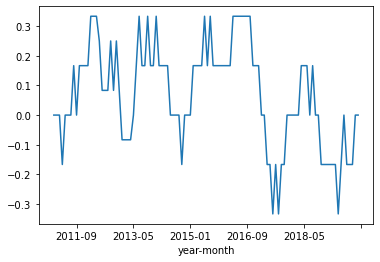

In [15]:
ts_df['sign_dif'].rolling(window = 12).mean().plot()

In [16]:
ts_df['delta_lag'] = ts_df['delta'].shift(1)

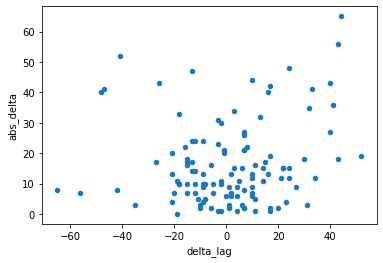

In [17]:
ts_df.plot.scatter(x='delta_lag' ,y='abs_delta')

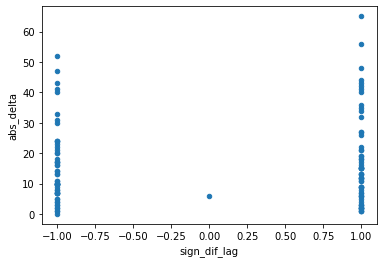

In [18]:
ts_df['sign_dif_lag'] = ts_df['sign_dif'].shift(1)
ts_df.plot.scatter(x='sign_dif_lag',y='abs_delta')

In [19]:
print (ts_df[['sign_dif_lag','abs_delta']].groupby('sign_dif_lag').mean(), ts_df[['sign_dif_lag','abs_delta']].groupby('sign_dif_lag').std() )

              abs_delta
sign_dif_lag           
-1.0          15.309091
 0.0           6.000000
 1.0          17.306452               abs_delta
sign_dif_lag           
-1.0          12.265388
 0.0                NaN
 1.0          14.821992


# Estimation

In [20]:
def ingarch_filter(w,a,b, con,r,p):
    dates = ts_df.index
    mu_est = [ts_df.loc[dates[1],'abs_delta'] ]
    p_est = [.5]
    
    for date in dates[2:]:
        y = ts_df.loc[date,'abs_delta']
        s = sgn(ts_df.loc[date,'delta'])
        mu_est.append(w + a*y + b*mu_est[-1])
        p_est.append(con + p*s + r*p_est[-1])
    
    filter_df = pd.DataFrame({'mu':mu_est,'prob':p_est})
    filter_df['year-month'] = dates[1:]
    return filter_df.set_index('year-month')

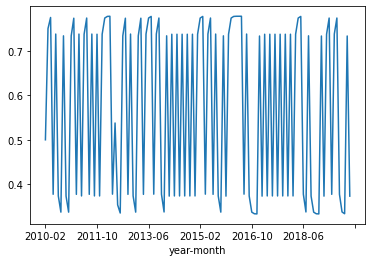

In [21]:
ingarch_filter(.1,.2,.5, .5,.1,.2)['prob'].plot()

In [22]:
ts_df.head()

,Y,delta,abs_delta,sign_dif,delta_lag,sign_dif_lag
year-month,,,,,,
2010-01,127,NaN,NaN,NaN,NaN,NaN
2010-02,106,-21.0,21.0,-1.0,NaN,NaN
2010-03,126,20.0,20.0,1.0,-21.0,-1.0
2010-04,128,2.0,2.0,1.0,20.0,1.0
2010-05,115,-13.0,13.0,-1.0,2.0,1.0


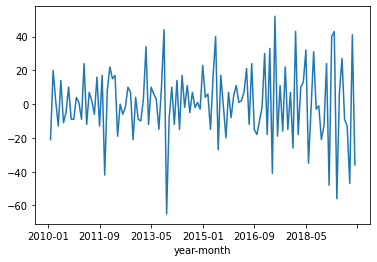

In [23]:
ts_df['delta'].plot()

0.8235294117647058